In [1]:
import preamble
import numpy as np
from phrase_trials_dataset import PhraseForceTrialDataset

ANGLE = 5.0 * np.pi / 4.0
TRANSFORMATION = np.array([
    [np.cos(ANGLE), -np.sin(ANGLE), 0.0],
    [np.sin(ANGLE),  np.sin(ANGLE), 0.0],
    [0.0, 0.0, 1.0]
])

phrase2force_dataset = PhraseForceTrialDataset('../data/phrase2force', TRANSFORMATION)
phrase2force_dataset[1,1]

,user_id,trial_number,phrase,adverb,first_cartesian_direction,second_cartesian_direction,time,dt,position_0,position_1,position_2,velocity_0,velocity_1,velocity_2,external_force_0,external_force_1,external_force_2,internal_force_0,internal_force_1,internal_force_2
0,1,1,down,,down,,0.001501,0.002461,0.691384,-0.173716,0.907901,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,down,,down,,0.003962,0.002103,0.691364,-0.173738,0.907939,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,down,,down,,0.006065,0.002090,0.691369,-0.173731,0.907951,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,down,,down,,0.008154,0.002486,0.691388,-0.173705,0.907907,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,down,,down,,0.010641,0.002495,0.691383,-0.173759,0.907912,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,1,1,down,,down,,2.104562,0.002497,0.706523,-0.169462,0.684336,-0.001907,-0.001374,-0.006766,0.0,0.0,0.0,0.0,0.0,0.0
890,1,1,down,,down,,2.107059,0.002496,0.706507,-0.169515,0.684299,-0.001782,-0.001334,-0.006778,0.0,0.0,0.0,0.0,0.0,0.0
891,1,1,down,,down,,2.109555,0.002495,0.706458,-0.169529,0.684308,-0.001885,-0.001316,-0.006394,0.0,0.0,0.0,0.0,0.0,0.0
892,1,1,down,,down,,2.112050,0.002499,0.706495,-0.169494,0.684271,-0.001847,-0.001250,-0.006902,0.0,0.0,0.0,0.0,0.0,0.0


external_force_0   -0.531196
external_force_1    0.081605
external_force_2   -0.292037
dtype: float64
external_force_0    5.902807
external_force_1    6.491748
external_force_2    6.603080
dtype: float64


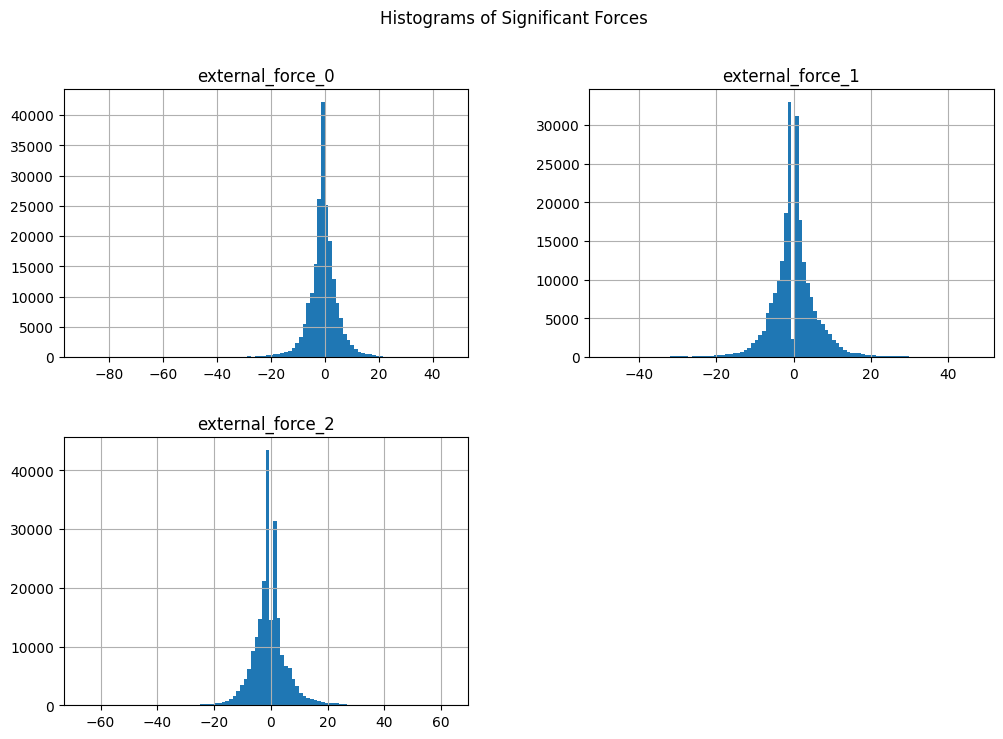

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

DEADBAND = 0.5

everyone = pd.concat(phrase2force_dataset[:], ignore_index=True)

EXTERNAL_FORCE_COLUMNS = [f'external_force_{i}' for i in range(3)]

all_forces = everyone[EXTERNAL_FORCE_COLUMNS]

all_significant_forces = all_forces.where(all_forces.abs() > DEADBAND)

ALL_SIGNIFICANT_FORCES_MEANS = all_significant_forces.mean(axis=0, skipna=True)
ALL_SIGNIFICANT_FORCES_STD = all_significant_forces.std(axis=0, skipna=True)

print(ALL_SIGNIFICANT_FORCES_MEANS)
print(ALL_SIGNIFICANT_FORCES_STD)

all_significant_forces.hist(bins=100, figsize=(12, 8))
plt.suptitle('Histograms of Significant Forces')
plt.show()

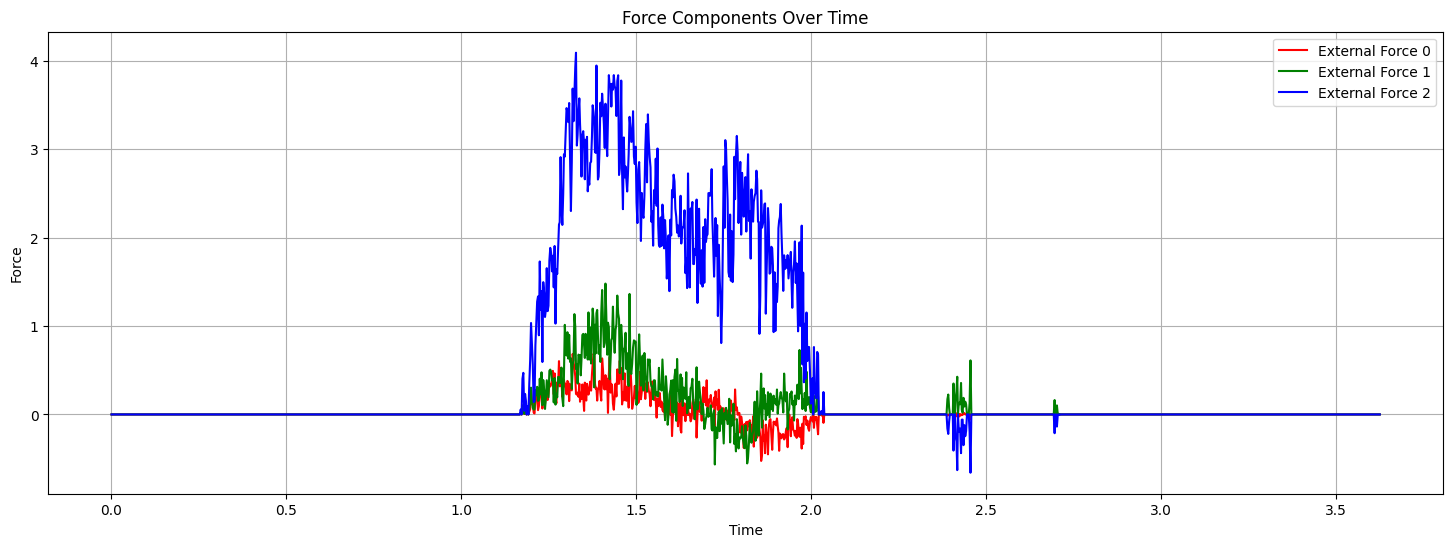

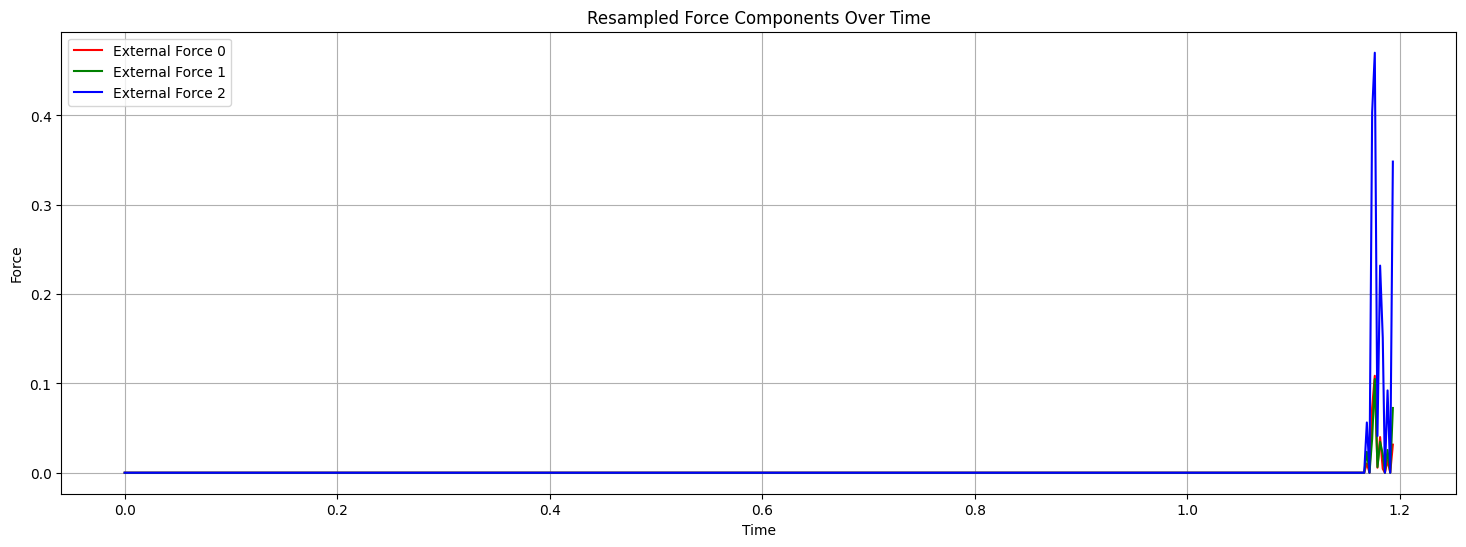

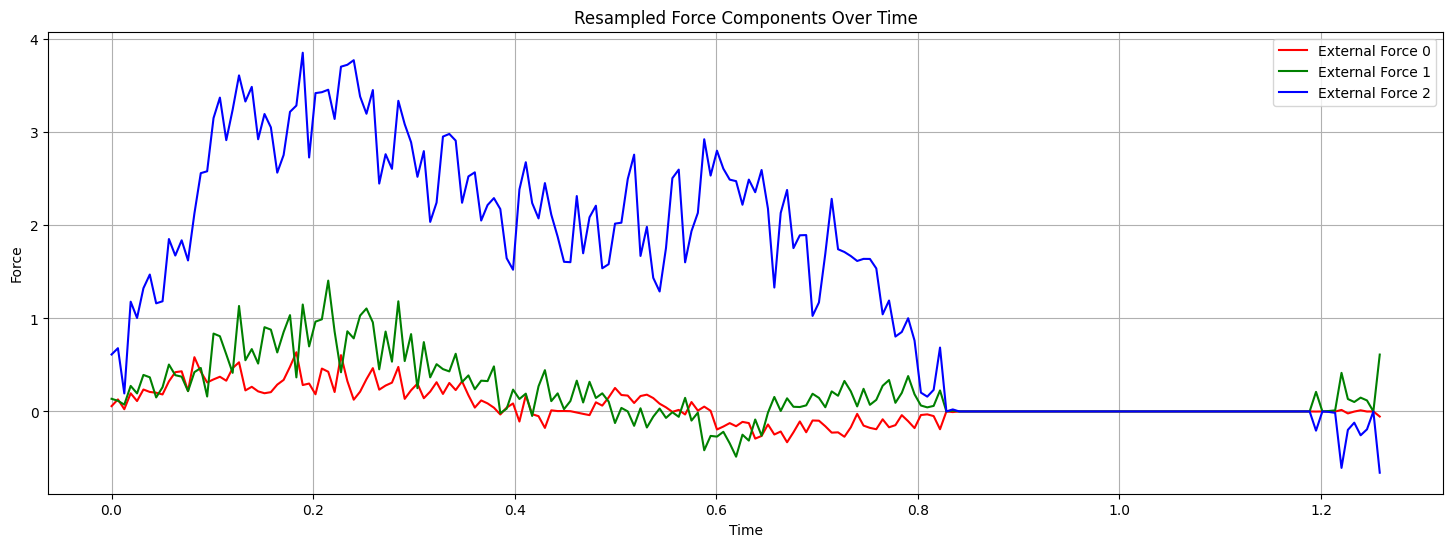

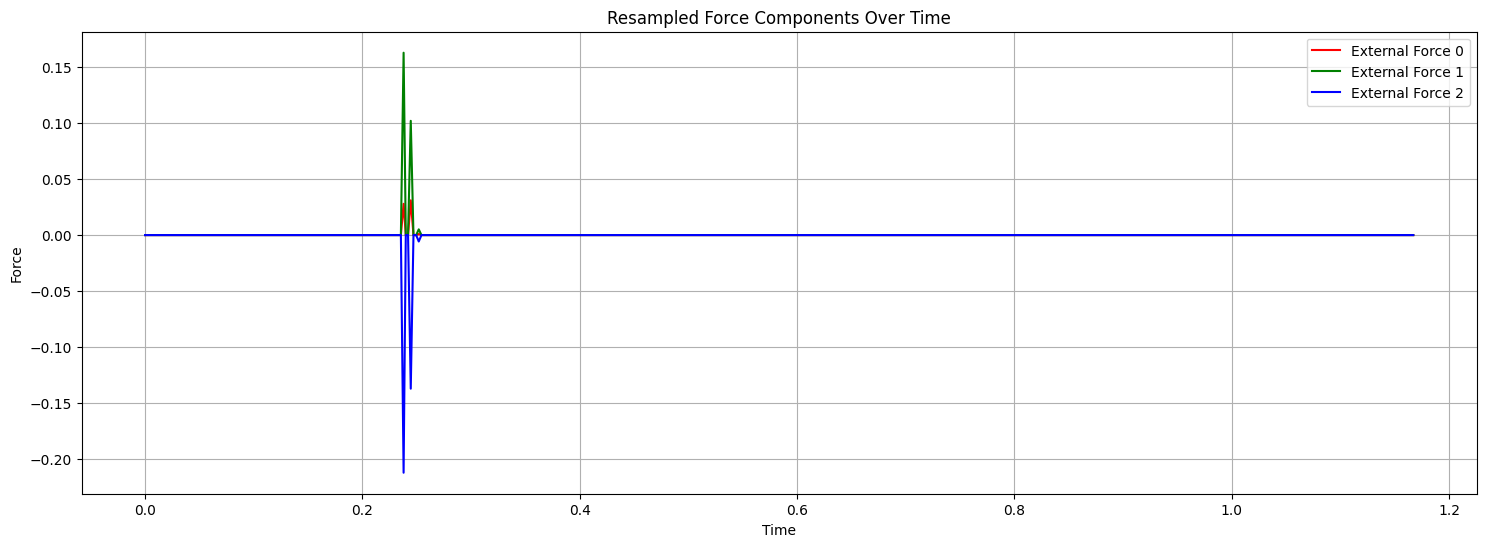

In [3]:
def trim_trial(trial):
    indices = np.arange(len(trial))
    filtered_indices = indices[(trial[EXTERNAL_FORCE_COLUMNS].abs() > DEADBAND).any(axis=1)]
    first, last = filtered_indices[0], filtered_indices[-1]
    pre_trial, trimmed_trial, post_trial = trial.iloc[:first].copy(), trial.iloc[first:last+1].copy(), trial.iloc[last+1:].copy()
    for trial in [pre_trial, trimmed_trial, post_trial]:
        trial['time'] = trial['time'] - trial['time'].min()
    return pre_trial if len(pre_trial) > 0 else None, trimmed_trial if len(trimmed_trial) > 0 else None, post_trial if len(post_trial) > 0 else None

def resample_trial(trial, N=200):
    if trial is None:
        return None
    resampled_trial = pd.DataFrame()
    resampled_trial['time'] = np.linspace(trial['time'].min(), trial['time'].max(), N)
    for external_force_column in EXTERNAL_FORCE_COLUMNS:
        resampled_trial[external_force_column] = np.interp(resampled_trial['time'], trial['time'], trial[external_force_column])
    return resampled_trial

original_trial = phrase2force_dataset[4,35]
pre_trial, trimmed_trial, post_trial = trim_trial(original_trial)
resampled_pre_trial, resampled_trial, resampled_post_trial = resample_trial(pre_trial), resample_trial(trimmed_trial), resample_trial(post_trial)

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(original_trial['time'], original_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(pre_trial['time'], pre_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Resampled Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(resampled_trial['time'], resampled_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Resampled Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(post_trial['time'], post_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Resampled Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

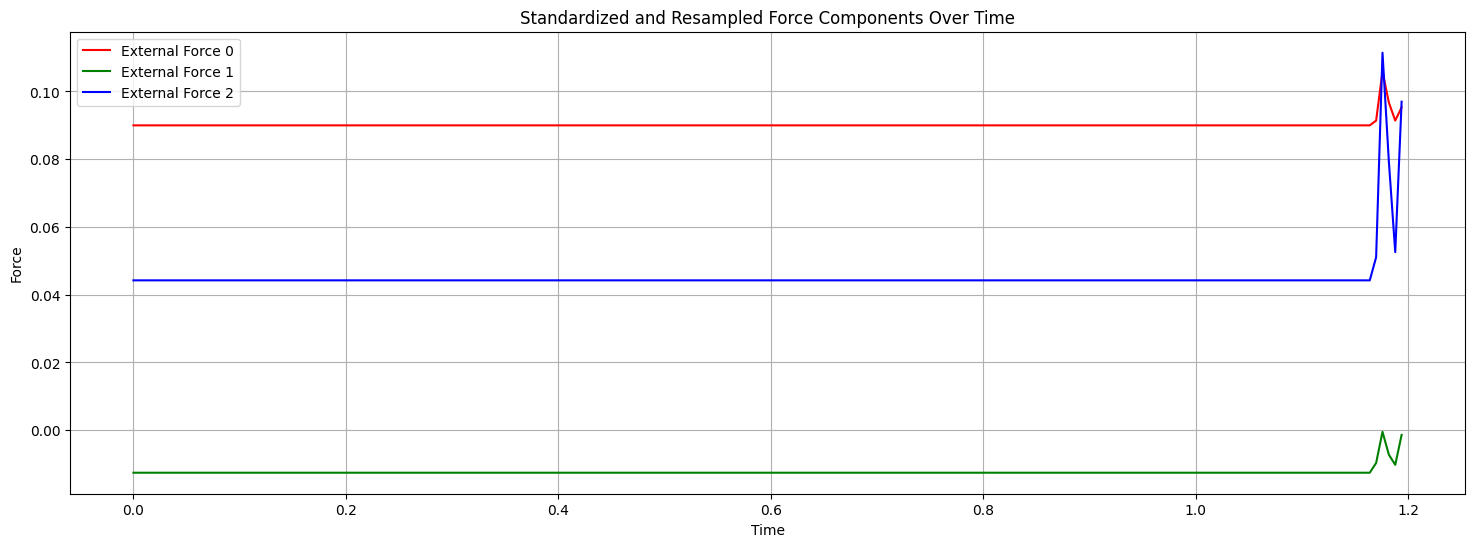

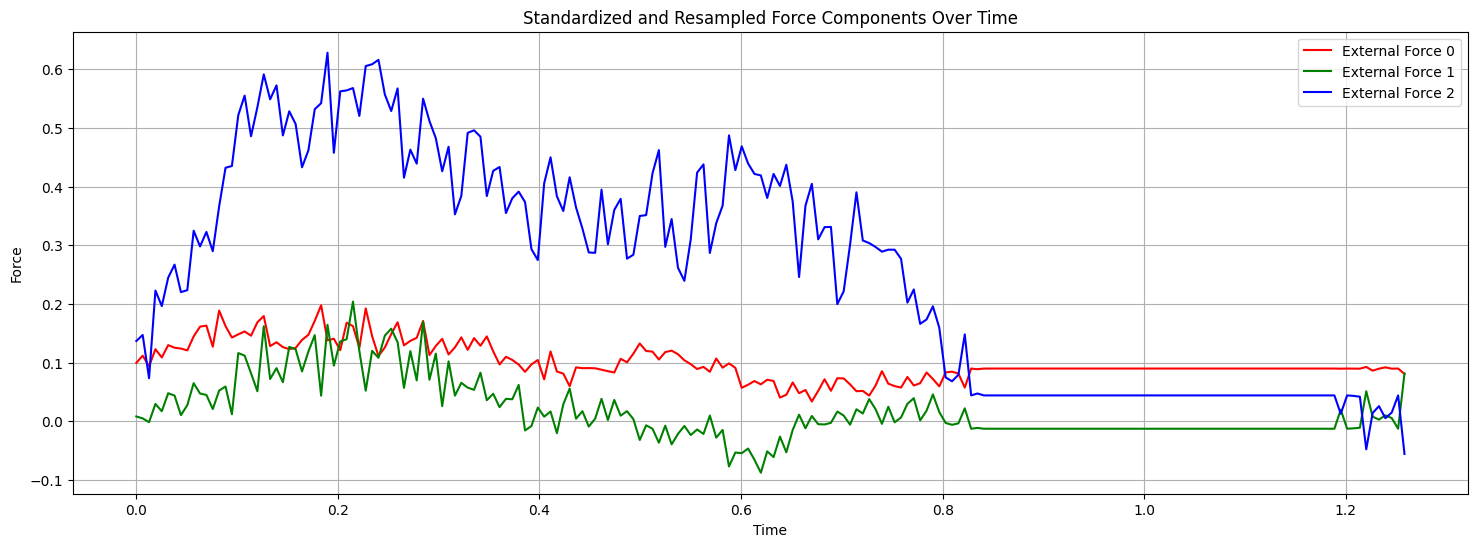

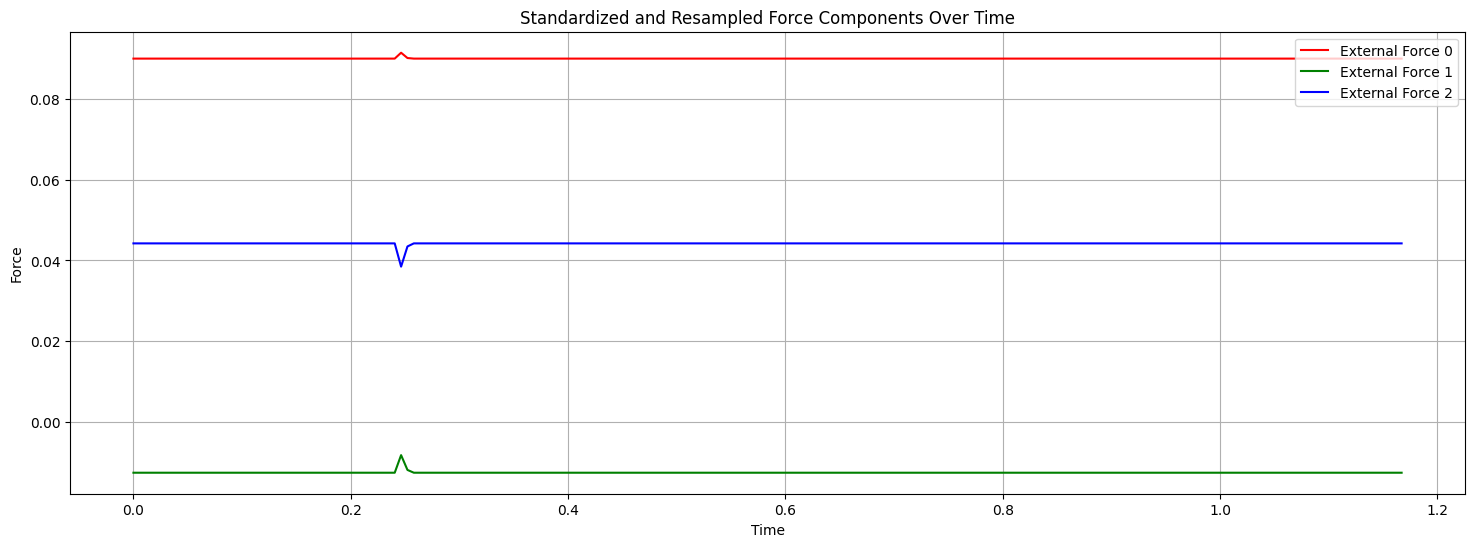

In [4]:
def standardize_trial(trial):
    if trial is None:
        return None
    standardized_trial = trial.copy()
    for external_force_column in EXTERNAL_FORCE_COLUMNS:
        standardized_trial[external_force_column] = (trial[external_force_column] - ALL_SIGNIFICANT_FORCES_MEANS[external_force_column]) / ALL_SIGNIFICANT_FORCES_STD[external_force_column]
    return standardized_trial

standardized_and_resampled_pre_trial, standardized_and_resampled_trial, standardized_and_resampled_post_trial = standardize_trial(resampled_pre_trial), standardize_trial(resampled_trial), standardize_trial(resampled_post_trial)

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(standardized_and_resampled_pre_trial['time'], standardized_and_resampled_pre_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Standardized and Resampled Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(standardized_and_resampled_trial['time'], standardized_and_resampled_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Standardized and Resampled Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 6))
for i in range(len(EXTERNAL_FORCE_COLUMNS)):
    plt.plot(standardized_and_resampled_post_trial['time'], standardized_and_resampled_post_trial[f'external_force_{i}'], label=f'External Force {i}', color='rgb'[i])
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Standardized and Resampled Force Components Over Time')
plt.legend()
plt.grid()
plt.show()

In [5]:
import torch

VOCABULARY = {
    'adverb': [
        'slightly',
        'greatly',
        'smoothly',
        'sharply',
        'slowly',
        'quickly',
        'lightly',
        'significantly',
        'softly',
        'harshly',
        'gradually',
        'immediately',
    ],
    'direction': {
        'X': {
            'left': [
                'left',
                'leftward',
                'to the left'
            ],
            
            'right': [
                'right',
                'rightward',
                'to the right',
            ],
        },
        'Y': {
            'forward': [
                'forward',
                'ahead',
                'to the front',
            ],
            'backward': [
                'backward',
                'behind',
                'to the back',
            ],
        },
        'Z': {
            'up': [
                'up',
                'upward',
                'above',
            ],
            'down': [
                'down',
                'downward',
                'below',
            ],
        },
    },
}

CARTESIAN_AXES = set(VOCABULARY['direction'].keys())
CARTESIAN_DIRECTIONS = {direction for axes_directions in VOCABULARY['direction'].values() for direction in axes_directions.keys()}
CARTESIAN_DIRECTION_TO_AXIS = {direction: axis for axis, axis_directions in VOCABULARY['direction'].items() for direction in axis_directions.keys()}
DIRECTION_PART_TO_AXIS = {direction_part: axis for axis, axis_directions in VOCABULARY['direction'].items() for direction_parts in axis_directions.values() for direction_part in direction_parts}
DIRECTION_PART_TO_CARTESIAN_DIRECTION = {direction_part: direction for axis_directions in VOCABULARY['direction'].values() for direction, direction_parts in axis_directions.items() for direction_part in direction_parts}

ADVERBS = sorted(VOCABULARY['adverb'] + [''])

CARTESIAN_DIRECTIONS = sorted(list(CARTESIAN_DIRECTIONS) + [''])

print(ADVERBS)
print(CARTESIAN_DIRECTIONS)

def encode_phrase(adverb, first_cartesian_direction, second_carteisian_direction):
    def one_hot_encode(value, categories):
        one_hot_vector = torch.zeros(len(categories))
        if value in categories:
            one_hot_vector[categories.index(value)] = 1
        else:
            raise ValueError(f'value {value} not in categories {categories}')
        return one_hot_vector

    while adverb not in ADVERBS:
        adverb = input(f"Invalid adverb '{adverb}'. Please enter a valid adverb: ")

    while first_cartesian_direction not in CARTESIAN_DIRECTIONS:
        first_cartesian_direction = input(f"Invalid direction '{first_cartesian_direction}'. Please enter a valid direction: ")

    while second_carteisian_direction not in CARTESIAN_DIRECTIONS:
        second_carteisian_direction = input(f"Invalid direction '{second_carteisian_direction}'. Please enter a valid direction: ")

    adverb_one_hot = one_hot_encode(adverb, ADVERBS)
    first_direction_one_hot = one_hot_encode(first_cartesian_direction, CARTESIAN_DIRECTIONS)
    second_direction_one_hot = one_hot_encode(second_carteisian_direction, CARTESIAN_DIRECTIONS)

    phrase_one_hot = torch.cat((adverb_one_hot, first_direction_one_hot, second_direction_one_hot))

    return phrase_one_hot, adverb_one_hot, first_direction_one_hot, second_direction_one_hot

['', 'gradually', 'greatly', 'harshly', 'immediately', 'lightly', 'quickly', 'sharply', 'significantly', 'slightly', 'slowly', 'smoothly', 'softly']
['', 'backward', 'down', 'forward', 'left', 'right', 'up']


In [6]:
import torch

def compose_multimodal_pair(trial):
    pre_trial, trimmed_trial, post_trial = trim_trial(trial)
    resampled_pre_trial, resampled_trial, resampled_post_trial = resample_trial(pre_trial), resample_trial(trimmed_trial), resample_trial(post_trial)
    standardized_and_resampled_pre_trial, standardized_and_resampled_trial, standardized_and_resampled_post_trial = standardize_trial(resampled_pre_trial), standardize_trial(resampled_trial), standardize_trial(resampled_post_trial)

    force_time_series_tensor_pre_trial, force_time_series_tensor_trial, force_time_series_tensor_post_trial = torch.tensor(standardized_and_resampled_pre_trial.values, dtype=torch.float32).T if standardized_and_resampled_pre_trial is not None else None, torch.tensor(standardized_and_resampled_trial.values, dtype=torch.float32).T if standardized_and_resampled_trial is not None else None, torch.tensor(standardized_and_resampled_post_trial.values, dtype=torch.float32).T if standardized_and_resampled_post_trial is not None else None

    phrase, adverb, first_cartesian_direction, second_cartesian_direction = trial[['phrase', 'adverb', 'first_cartesian_direction', 'second_cartesian_direction']].iloc[0]
    phrase_one_hot, adverb_one_hot, first_cartesian_direction_one_hot, second_cartesian_direction_one_hot = encode_phrase(adverb, first_cartesian_direction, second_cartesian_direction)

    no_action_phrase, no_action_adverb, no_action_first_cartesian_direction, no_action_second_cartesian_direction = ['']*4
    no_action_phrase_one_hot, no_action_adverb_one_hot, no_action_first_cartesian_direction_one_hot, no_action_second_cartesian_direction_one_hot = encode_phrase(no_action_adverb, no_action_first_cartesian_direction, no_action_second_cartesian_direction)

    return {
        'force': force_time_series_tensor_pre_trial,

        'phrase': no_action_phrase,
        'phrase_one_hot': no_action_phrase_one_hot,

        'adverb': no_action_adverb,
        'adverb_one_hot': no_action_adverb_one_hot,

        'first_cartesian_direction': no_action_first_cartesian_direction,
        'first_cartesian_direction_one_hot': no_action_first_cartesian_direction_one_hot,
        
        'second_cartesian_direction': no_action_second_cartesian_direction,
        'second_cartesian_direction_one_hot': no_action_second_cartesian_direction_one_hot,
    } if force_time_series_tensor_pre_trial is not None else None, {
        'force': force_time_series_tensor_trial,

        'phrase': phrase,
        'phrase_one_hot': phrase_one_hot,

        'adverb': adverb,
        'adverb_one_hot': adverb_one_hot,

        'first_cartesian_direction': first_cartesian_direction,
        'first_cartesian_direction_one_hot': first_cartesian_direction_one_hot,

        'second_cartesian_direction': second_cartesian_direction,
        'second_cartesian_direction_one_hot': second_cartesian_direction_one_hot,
    } if force_time_series_tensor_trial is not None else None, {
        'force': force_time_series_tensor_post_trial,

        'phrase': no_action_phrase,
        'phrase_one_hot': no_action_phrase_one_hot,

        'adverb': no_action_adverb,
        'adverb_one_hot': no_action_adverb_one_hot,

        'first_cartesian_direction': no_action_first_cartesian_direction,
        'first_cartesian_direction_one_hot': no_action_first_cartesian_direction_one_hot,
        
        'second_cartesian_direction': no_action_second_cartesian_direction,
        'second_cartesian_direction_one_hot': no_action_second_cartesian_direction_one_hot,
    } if force_time_series_tensor_post_trial is not None else None

import os

def save_multimodal_pairs(trials, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    unique_id = 0
    for i, trial in enumerate(trials):
        for j, multimodal_pair in enumerate(compose_multimodal_pair(trial)):
            if multimodal_pair is not None:
                save_path = os.path.join(save_dir, f'{unique_id}__multimodal_pair.pt' if j == 1 else f'{unique_id}__multimodal_pair__no_action.pt')
                torch.save(multimodal_pair, save_path)
            unique_id += 1

In [7]:
# save_multimodal_pairs(phrase2force_dataset[:], '../data/global_standardized_and_absolute_time_channel_multimodal_pairs')

In [9]:
# import time

# class Timer:
#     def __init__(self) -> None:
#         self.reset()

#     def dt(self) -> float:
#         t = self.t()
#         dt = t - self.last_t
#         self.last_t = t
#         return dt

#     def t(self) -> float:
#         return time.time() - self.start_time

#     def reset(self) -> None:
#         self.start_time = time.time()
#         self.last_t = 0.0


# class ForceCurve:
#     def __init__(self, direction, duration, peak_force, ramp_up_pct=0.5, hold_pct=0.0, ramp_down_pct=0.5):
#         self.direction = direction
#         self.ramp_up_time = ramp_up_pct * duration
#         self.hold_time = hold_pct * duration
#         self.ramp_down_time = ramp_down_pct * duration
#         self.duration = duration
#         self.peak_force = peak_force
#         self.start_time = 0.0
#         self.stop_time = 0.0
    
#     def start(self):
#         self.start_time = time.time()
    
#     def stop(self):
#         self.stop_time = time.time()
    
#     def get_force(self):
#         t = time.time() - self.start_time
#         if t <= self.ramp_up_time:
#             magnitude = self.peak_force * t / self.ramp_up_time
#         elif t <= self.hold_time:
#             magnitude = self.peak_force
#         elif t <= self.ramp_down_time:
#             magnitude = self.peak_force * (1.0 - (t - self.ramp_up_time - self.hold_time) / self.ramp_down_time)
#         else:
#             magnitude = 0.0
        
#         is_done = t > self.duration
#         if is_done:
#             self.stop()

#         return self.direction * magnitude, is_done

# force2phrase_dataset = PhraseForceTrialDataset('../data/force2phrase', TRANSFORMATION)

# for i in range(len(force2phrase_dataset)):
#     force2phrase_dataset[i].drop(columns=['external_force_0', 'external_force_1', 'external_force_2'], inplace=True)

#     force2phrase_dataset[i].rename(columns={
#         'internal_force_0': 'external_force_0',
#         'internal_force_1': 'external_force_1',
#         'internal_force_2': 'external_force_2'
#     }, inplace=True)

# everyone_with_force2phrase = pd.concat(phrase2force_dataset[:] + force2phrase_dataset[:], ignore_index=True)

# all_forces = everyone_with_force2phrase[EXTERNAL_FORCE_COLUMNS]

# all_significant_forces = all_forces.where(all_forces.abs() > DEADBAND)

# ALL_SIGNIFICANT_FORCES_MEANS = all_significant_forces.mean(axis=0, skipna=True)
# ALL_SIGNIFICANT_FORCES_STD = all_significant_forces.std(axis=0, skipna=True)

# print(ALL_SIGNIFICANT_FORCES_MEANS)
# print(ALL_SIGNIFICANT_FORCES_STD)

# save_multimodal_pairs(phrase2force_dataset[:] + force2phrase_dataset[:], '../data/global_standardized_with_force2phrase_and_absolute_time_channel_multimodal_pairs')

external_force_0   -0.294817
external_force_1   -0.062426
external_force_2   -0.234605
dtype: float64
external_force_0    7.013498
external_force_1    7.435036
external_force_2    7.228189
dtype: float64
